### Projectile

# Body Diagram

Using Newton's Second Law:

$ \sum \vec{F} = m \vec{a} $

- Friction:

	We need to define the behaviour of the friction force.
	Using an usual friction defined as:

	$$ \vec{F_f} = -\beta |\vec{v}| \vec{v} $$

	where $\beta$ is the friction coefficient and $\vec{v}$ the velocity.

- Equations of motion:

	$\vec r = (x, y)$

	Applying Newton's Second Law to the horizontal and vertical directions:
	$$ \vec{F_g} + \vec{F_f} = m \ddot{\vec{r}} $$
	$$ \vec{F_g} + \vec{F_f} = m \ddot{x} \hat{x} + m \ddot{y} \hat{y} $$

	Separating the equations:

	$$ \vec{F_g} + \vec{F_f} = m \ddot{x} \hat{x} $$
	$$ \vec{F_g} + \vec{F_f} = m \ddot{y} \hat{y} $$

	Subsituting the friction force and the gravity force:
	$$ m \ddot{x} = -\beta |\vec{v}| \dot{x}  $$ 
	$$ m \ddot{y}  = -mg -\beta |\vec{v}| \dot{y}  $$

	Rearranging the equations and substituting r' = r/g (to use dimensionless units):
	$$ \ddot{x'} = -\frac{\beta g}{m} |\vec{v'}| \dot{x'} $$
	$$ \ddot{y'} = -1 -\frac{\beta g}{m} |\vec{v'}| \dot{y'} $$

We have 2 second order ODEs, we can separate them into 4 first order ODEs:
- $ \dot{x'} = v'_{x'} $
- $ \dot{y'} = v'_{y'} $
- $ \dot{v'_{x'}} = -\frac{\beta g}{m} |\vec{v'}| v'_{x'} $
- $ \dot{v'_{y'}} = -1 -\frac{\beta g}{m} |\vec{v'}| v'_{y'} $

	We can now apply the Runge-Kutta method to solve the ODEs. We will use the 4th order Runge-Kutta method. (Default in scipy.integrate.solve_ivp)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp

In [141]:
class Projectile():
	def __init__(self, r0, v0, thetas, t_span, B, m=9.81, g=9.81):
		"""
		Initializes a projectile object with initial position r0, initial velocity v0, time span t_span, air friction coeficient B and acceleration due to gravity g.
		"""
		self.t = t_span
		self.thetas = thetas
		self.x, self.y = r0
		self.v0 = v0
		self.vx, self.vy = v0*np.cos(thetas), v0*np.sin(thetas)

		self.B = B*g/m 
		self.S = [self.x, self.vx, self.y, self.vy]

	def dSdt(self, t, S, B):
		"""
		Returns the time derivative of the state vector S.
		"""
		x, vx, y, vy = self.S
		return [vx, -self.B*vx, vy, -1 - self.B*vy]
	
		self.dSdt = dSdt

	def trajectory(self):
		"""
		Returns the trajectory of the projectile (with aire resistance).
		"""
		return [solve_ivp(self.dSdt, self.t, [0, self.v0*np.cos(theta), 0, self.v0*np.sin(theta)], t_eval=np.linspace(*self.t, 100), args=(self.B,), dense_output=True) for theta in self.thetas]
		

	def peak(self):
		"""
		Returns the time, x and y coordinates of the peak of the projectile trajectory.
		"""
		return self.t[np.argmax(self.y)], self.x[np.argmax(self.y)], np.max(self.y)

In [142]:
# Initial conditions
r0 = (0, 0)
v = 5
thetas = np.linspace(0, np.pi/4, 10)
B = 10 	# beta * g / m 
t_span = (0, 3)

In [143]:
p = Projectile(r0, v, thetas, t_span, B)

In [144]:
p.trajectory()

ValueError: operands could not be broadcast together with shapes (4,10) (4,) 

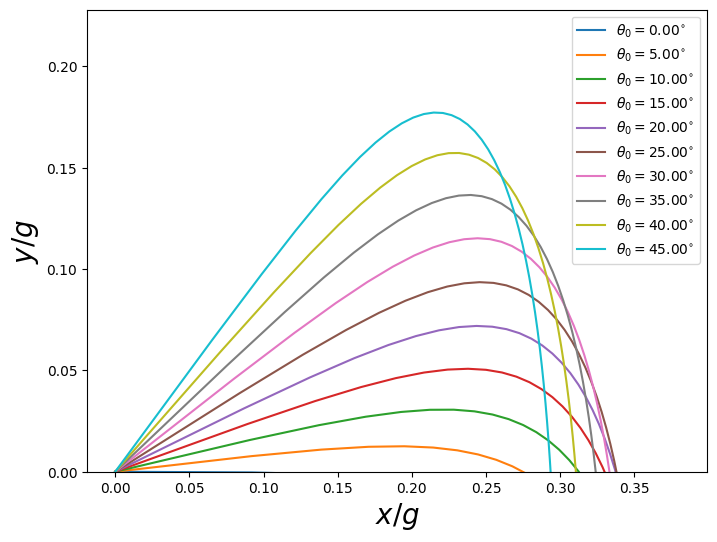

In [110]:
fig = plt.figure(figsize=(8, 6))
for sol in sols:
	plt.plot(sol.y[0], sol.y[2], label=r'$\theta_0={:.2f}^{{\circ}}$'.format(np.arctan(sol.y[3][0]/sol.y[1][0])*180/np.pi))
plt.ylim(bottom=0)
plt.legend()
plt.xlabel('$x/g$', fontsize=20)
plt.ylabel('$y/g$', fontsize=20)
plt.show()

In [145]:
class Projectile():
    def __init__(self, r0, v0, t, F, m, *args):
        self.t = t
        self.x0, self.y0 = r0
        self.vx0, self.vy0 = v0
        self.F = F
        self.m = m
        self.args = args
        
    def solve_motion(self):
        def dSdt(t, S, *args):
            x, vx, y, vy = S
            return [vx, self.F(t, x, y, vx, vy, self.m, *args)[0]/self.m,
                    vy, self.F(t, x, y, vx, vy, self.m, *args)[1]/self.m]
        self.solution = solve_ivp(dSdt, [min(self.t), max(self.t)],
                                  [self.x0, self.vx0, self.y0, self.vy0],
                                  t_eval=self.t, args=self.args)
        self.x, self.vx, self.y, self.vy = self.solution.y
        
    def get_peak_y(self):
        return max(self.y)
    
    def get_peak_x(self):
        return self.x[np.argmax(self.y)]
    
    def get_peak_t(self):
        return self.t[np.argmax(self.y)]
    
    def get_x_landing(self):
        x_after_peak = self.x[self.t>self.get_peak_t()]
        y_after_peak = self.y[self.t>self.get_peak_t()]
        return x_after_peak[np.argmin(np.abs(y_after_peak))]

In [147]:
def friction_1(t, x, vx, y, vy, m, g, B):
    # B = b * g / m - b is the friction coeficient normalized
    return [-B*np.sqrt(vx**2+vy**2)*vx, -B*np.sqrt(vx**2+vy**2)*vy - 1]

def friction_2(t, x, vx, y, vy, m, g, B):
    # B = b * g / m - b is the friction coeficient normalized
    return [-B*vx, -B*vy - 1]

In [148]:
# Initial conditions
r0 = (0, 0)
v0 = (5, 0)
t = np.linspace(0, 3, 100)
m = 9.81
g = 9.81
B = 10

In [155]:
p1 = Projectile(r0, v0, t, friction_1, m, g, B)
p2 = Projectile(r0, v0, t, friction_2, m, g, B)
p1.solve_motion()
p2.solve_motion()

In [156]:
p1.solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.030e-02 ...  2.970e+00  3.000e+00]
        y: [[ 0.000e+00  1.515e-01 ...  1.492e+01  1.507e+01]
            [ 5.000e+00  5.000e+00 ...  5.121e+00  5.126e+00]
            [ 0.000e+00 -4.680e-05 ... -3.770e-01 -3.833e-01]
            [ 0.000e+00 -3.089e-03 ... -2.067e-01 -2.070e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 38
     njev: 0
      nlu: 0